# Position Prediction for Football Players
**by Ciutat Vella Team**: Tatiana Bakwenye, Natalia Beltran, Mikel Gallo

##  Index 


0. [Set Up](#0-.Set-Up)
1. [Dataset Exploration](#1-.Dataset-Exploration)
2. [Handling Missing Data](#2-.Handling-Missing-Data)
3. [Data Exploration](#3-.Data-Exploration)
4. [Addressing Outliers and Unique Values](#4-.Addressing-Outliers-and-Unique-Values)
5. [Standarize Columns](#5-.Standarize-Columns)
6. [Train & Test Models ](#6-.Train-&-Test-Models)
7. [Final Model ](#7-.Final-Model)
8. [Conclusion: Important Features](#8-.Conclusion:-Important-Features)



## 0. Set Up

#### Import Packages 

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import seaborn as sns
import os
import math
import time
#import catboost
from scipy.stats import randint
# sklearn imports 
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import  TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE
#catboost model 
from catboost import CatBoostClassifier

#### Import Data

In [2]:
# Retrieve path and load the data
path = os.getcwd()
dr = pd.read_csv(path+"/train.csv")
dt = pd.read_csv(path+"/test.csv")

# Number of rows and columns
print('dr train', dr.shape)
print('df test', dt.shape)

dt.head(3)

dr train (6895, 70)
df test (767, 69)


,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,215562,R. Hunt,63,63,475000.0,3000,1995-07-07,171,67,Swindon Town,...,57,54,59,58,15,12,12,11,15,NaN
1,248311,Tiri,64,64,500000.0,950,1991-07-14,186,84,ATK Mohun Bagan FC,...,55,63,63,64,9,14,9,11,6,NaN
2,223933,G. Nilsson,64,70,925000.0,2000,1997-05-23,197,87,SV Wehen Wiesbaden,...,55,23,25,19,6,7,8,16,14,NaN


#### Merge Train and Test Datasets

Create function for merging train and test datasets

In [3]:
# Create column to differentiate train from test
dr['is_test'] = 0
dt['is_test'] = 1

In [4]:
# union both datasets
df = pd.concat([dr, dt])

In [5]:
# Unit test
dr.shape[0] + dt.shape[0] == df.shape[0]

True

In [6]:
# Unit test
df['is_test'].value_counts()

0    6895
1     767
Name: is_test, dtype: int64

#### Data Variable Breakdown

#### player identification and overall qualification variables  
- id: Unique identifier for each player.
- short_name: Short name or nickname of the player. [X]
- birthday_date: Player's date of birth. [X]
- height_cm: Player's height in centimeters. [D]
- weight_kg: Player's weight in kilograms. [D]

- overall: Player's overall rating, representing their overall skill level [D]
- potential: Player's potential rating, indicating their potential skill growth. [D]
- international_reputation: Player's international reputation level. [D]
- club_name: Name of the player's club.[X]
- league_name: Name of the league the club belongs to.[D]
- league_level [D]
- club_jersey_number [D]
- club_loaned_from [X]
- club_joined [X]
- club_contract_valid_until [X]
- nationality_name [D]
- nation_jersey_number [X]

- work_rate [D]
- body_type [D]
- real_face [X]
- player_tags [X]
- player_traits [D]
  
#### player financial metrics  
- value_eur: Player's market value in euros.
- wage_eur: Player's weekly wage in euros.
- release_clause_eur

  
#### player position related metrics  
- position: Player's preferred playing position.[TARGET VARIABLE]
- preferred_foot: Player's preferred kicking foot (left or right).
- weak_foot: Player's weak foot rating, indicating their weaker kicking foot's ability.

#### Skills
- skill_dribbling
- skill_curve
- skill_fk_accuracy
- skill_long_passing
- skill_ball_control
- skill_moves: Player's skill moves rating, representing their dribbling and ball control skills.

#### high level attributes  
- pace 
- shooting 
- passing 
- dribbling 
- defending 
- physic: Attributes representing different aspects of a player's playing style and skills.

#### mentality attributes  
- mentality_aggression
- mentality_vision
- mentality_composure: Attributes representing mental aspects of a player's game.
- mentality_interceptions
- mentality_positioning
- mentality_penalties
   
#### attacking attributes  
- attacking_crossing
- attacking_finishing 
- attacking_heading_accuracy: Attributes related to attacking and finishing skills.'attacking_crossing', 
- attacking_heading_accuracy
- attacking_short_passing
- attacking_volleys

#### movement attributes 
- movement_acceleration
- movement_sprint_speed
- movement_agility: Attributes related to a player's speed and agility.
- movement_reactions
- movement_balance

#### strength attributes 
- power_shot_power
- power_jumping
- power_stamina: Attributes representing a player's physical power and endurance.
- power_strength
- power_long_shots

#### defending attributes
- defending_marking_awareness
- defending_standing_tackle
- defending_sliding_tackle: Attributes representing a player's defensive skills.


#### Goalkeeper attributes  

- goalkeeping_diving
- goalkeeping_handling
- goalkeeping_positioning: Goalkeeping attributes related to diving, handling, and positioning.
- goalkeeping_reflexes
- goalkeeping_speed: Attributes representing a goalkeeper's reflexes and speed.
- goalkeeping_kicking


## 1. Dataset Exploration

## 2. Handling Missing Data 

#### Checking for Missing Values  

This allows us to determine how many missing values we have in our dataset and how to proceed with cleaning and imputing the data. 

In [7]:
# Function to create table of missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

                # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [8]:
# Check the percent of NAs
print(missing_values_table(df))

Your selected dataframe has 71 columns.
There are 15 columns that have missing values.
                      Missing Values  % of Total Values
club_loaned_from                7266               94.8
nation_jersey_number            7198               93.9
goalkeeping_speed               6961               90.9
player_tags                     6806               88.8
player_traits                   2874               37.5
position                         767               10.0
pace                             701                9.1
shooting                         701                9.1
passing                          701                9.1
dribbling                        701                9.1
defending                        701                9.1
physic                           701                9.1
release_clause_eur               401                5.2
club_joined                      396                5.2
value_eur                          5                0.1


Can be dropped:
- club_loaned_from
- nation_jersey_number
- player_tags

Needs transformation: 
- goalkeeping_speed
- player_traits

From table we can see a really high percentage of missing values for variables 'club_loaned_from', 'nation_jersey_number', 'player_tags'. Due to almost all three of the variables being around or above 90%, we will be dropping it them as there is very little values given to be able to properly impute the columns. 

##### Variable Dropping with High Missing Values 

In [9]:
columns_to_drop = ['club_loaned_from', 'nation_jersey_number', 'player_tags']
df = df.drop(columns=columns_to_drop)

##### Variable Transformation with NAs for Goalkeeping speed

When examining the goalkeeping_speed variable, we are able to see that the data is not missing at random. There are less players overall who play in the position of goalkeeper, so the number of missing values makes sense to be higher as there will be a lower percentage of players that play in that position overall. 

The players who position is goalkeeper in the train dataset have been correctly assigned. We impute the variable to give all the NAs in the column 0s, to seperate those who are assigned goalkeepers to the rest of the positions. 

In [10]:
# Function to impute NA with 0 
def impute_column_with_zero(df, column_name):
    df[column_name] = df[column_name].fillna(0)
    return df

df = impute_column_with_zero(df, 'goalkeeping_speed')

In [11]:
# Check the NAs
print(missing_values_table(df))

Your selected dataframe has 68 columns.
There are 11 columns that have missing values.
                    Missing Values  % of Total Values
player_traits                 2874               37.5
position                       767               10.0
pace                           701                9.1
shooting                       701                9.1
passing                        701                9.1
dribbling                      701                9.1
defending                      701                9.1
physic                         701                9.1
release_clause_eur             401                5.2
club_joined                    396                5.2
value_eur                        5                0.1


For the rest of the variables with missing values we will be imputing them using different methods is section ###. 

#### Feature Engineering: Age, years in the club, position orientation


The current dataset does not provide the players current age which we believe to be an important factor in determining the position of a player. As those who are older tend to be play in slower postions such as defense, and younger players tend to play further as strikers or midfielders as they are more active roles on the field and require more stamina. We created the age feature from todays, date subtracting the birthdate of the players. Then, we created a new column called age seperate to the birthdate column. 

We also saw that it would be more beneficial to know how long a player has been with a club than when they joined, as the longer they have been in the program the more they have developed as players and in certain positions. This can potentially give us more information on player traits and physic to help understand the positions. 

##### Create function for calculating players age

In [12]:
# Calculate age of players
df['birthday_date'] = pd.to_datetime(df['birthday_date'], format='%Y-%m-%d', errors='coerce')
df['today'] = pd.to_datetime('2022-11-01',format='%Y-%m-%d', errors='coerce')

# Create the new age column 
df['age'] = ((df['today'] - df['birthday_date'])/np.timedelta64(1, 'Y'))
df['age'] = df['age'].astype(int)

##### Create function for calculating years in the club 

In [13]:
# Calculate the number of years in the club
df['club_joined'] = pd.to_datetime(df['club_joined'], format='%Y-%m-%d', errors='coerce')
df['today'] = pd.to_datetime('2022-11-01', format='%Y-%m-%d', errors='coerce')

# Calculate the years_in_club only if 'club_joined' is not NA
df['years_in_club'] = np.where(df['club_joined'].notna(), ((df['today'] - df['club_joined']) / np.timedelta64(1, 'Y')), np.nan)
df['years_in_club'] = df['years_in_club'].astype(float).round(2)

# Drop the 'club_joined' column
df = df.drop('club_joined', axis=1)

##### KNN Imputation for Most of the Remaining NAs 

We settled for the tunning of the number neighbors to use for kneighbors to be n_neighbors = 3. Other values were tested but this gave the best performance for our model. 

In [14]:
# Specify the columns to impute
columns_to_impute = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'release_clause_eur', 'value_eur', 'years_in_club']

# Create a KNNImputer object with k=3 
imputer = KNNImputer(n_neighbors=3) 

# Perform KNN imputation only on the specified columns for the training data
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

The variable player_traits will be looked at further in the Addressing Outliers and Unique values section, in order to understand deeper the different unique values it has and how to better approach dealing the NAs.  

## 3. Data Exploration

### Create broader categories for positions

Grouping player positions into broader categories enables us to assess the correlation between various numerical and categorical variables and a player's actual position. By identifying whether players hold defensive, creative, or attacking positions, or if they play in the wings or central areas, we aim to uncover patterns in the data that can assist us in identifying key features.

In [15]:
df.position.unique()

array(['LB', 'LDM', 'LWB', 'LS', 'RW', 'GK', 'LCM', 'RM', 'RCM', 'LW',
       'LCB', 'RB', 'RCB', 'CDM', 'RDM', 'CAM', 'CB', 'ST', 'RS', 'LM',
       'RWB', 'LF', 'RF', 'CM', nan], dtype=object)

In [16]:
# Creating high-level positions (['Goalkeeper', 'Defense', 'Midfield', 'Attack'])
conditions = [
    df['position'].isin(['GK']),
     df['position'].isin(['LB','LCB','CB','RCB','RB','LWB','LDM','CDM','RDM','RWB']),
     df['position'].isin(['LM','LCM','CM','RCM','RM']),
     df['position'].isin(['LAM','CAM','RAM','LW','LF','CF','RF','RW','LS','ST','RS'])
     
]

choices = ['Goalkeeper', 'Defense', 'Midfield', 'Attack']

df['job'] = np.select(conditions, choices, default='other')

In [17]:
# Creating high-level positions (['Goalkeeper', 'Defense', 'Midfield', 'Attack'])
conditions = [
    df['position'].isin(['GK']),
     df['position'].isin(['LB','LCB','CB','RCB','RB','LWB','LDM','CDM','RDM','RWB']),
     df['position'].isin(['LM','LCM','CM','RCM','RM']),
     df['position'].isin(['LAM','CAM','RAM','LW','LF','CF','RF','RW','LS','ST','RS'])
     
]

choices = [0, 1, 2, 3]

df['job_order'] = np.select(conditions, choices, default=-1)

In [18]:
# Creating high position location
conditions = [
    df['position'].isin(['LB','LWB','LM','LW','RB','RWB','RM','RW'])
     
]

choices = ['yes']

df['is_wing'] = np.select(conditions, choices, default='no')

In [19]:
# extract the side of the player from the position L or R
df.loc[:, "side"] = df.loc[:, "position"].str[0]

In [20]:
conditions = [
    df['side'].isin(['G']),
     df['side'].isin(['C']),
     df['side'].isin(['L']),
     df['side'].isin(['R']),
     df['side'].isin(['S']),
     
]

choices = [0,1,2,3,4]

df['side_order'] = np.select(conditions, choices, default=np.NaN)

### Create a copy of df without GK

In [21]:
dk = df[(df['position']!= 'GK')&(df['is_test']== 0)]

In [22]:
# Unit test
print(df.shape)
print(dk.shape)

(7662, 75)
(6264, 75)


### Functions for Feature Analysis

In [23]:
def plot_hist_mult_h2(data, var1, var2, hue_var):
    sns.set(style="darkgrid")

    num_variables = min(var1 * var2, data.shape[1])  # Use the minimum of specified subplots and number of variables
    var1 = (num_variables + var2 - 1) // var2  # Adjust var1 based on the number of variables

    fig, axes = plt.subplots(var1, var2, sharey=False, figsize=(12, 10), squeeze=False, subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

    for i, el in enumerate(list(data.columns.values[:num_variables])):
        row = i // var2
        col = i % var2

        # Plot density plot for each category using sns.kdeplot
        for j, category in enumerate(data[hue_var].unique()):
            subset = data[data[hue_var] == category]
            sns.kdeplot(data=subset[el], fill=True, alpha=0.5, label=category, ax=axes[row, col], color=sns.color_palette('husl')[j])

        axes[row, col].set_title(f'Density Plot of {el}', fontsize=12)
        axes[row, col].set_xlabel(el, fontsize=10)
        axes[row, col].set_ylabel('Density', fontsize=10)
        axes[row, col].legend()

    plt.show()


In [24]:
def plot_hist_mult_h3(data, var1, var2, hue_var):
    sns.set(style="darkgrid")

    num_variables = min(var1 * var2, data.shape[1])  # Use the minimum of specified subplots and number of variables
    var1 = (num_variables + var2 - 1) // var2  # Adjust var1 based on the number of variables

    fig, axes = plt.subplots(var1, var2, sharey=False, figsize=(12, 10), squeeze=False, subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

    for i, el in enumerate(list(data.columns.values[:num_variables])):
        row = i // var2
        col = i % var2

        # Check if the variable is numeric or datetime
        if data[el].dtype.name in ['int64', 'float64', 'datetime64[ns]']:
            # Plot density plot for each category using sns.kdeplot
            for j, category in enumerate(data[hue_var].unique()):
                subset = data[data[hue_var] == category]
                sns.kdeplot(data=subset[el], fill=True, alpha=0.5, label=category, ax=axes[row, col], color=sns.color_palette('husl')[j],warn_singular=False)

            axes[row, col].set_title(f'Density Plot of {el}', fontsize=12)
            axes[row, col].set_xlabel(el, fontsize=10)
            axes[row, col].set_ylabel('Density', fontsize=10)
            #axes[row, col].legend()
        else:
            # Use count plot for categorical variables
            sns.countplot(x=el, data=data, hue=hue_var, ax=axes[row, col])
            axes[row, col].set_title(f'Count Plot of {el}', fontsize=12)
            axes[row, col].set_xlabel(el, fontsize=10)
            axes[row, col].set_ylabel('Count', fontsize=10)
            #axes[row, col].legend()

    plt.show()

### Studying player characteristics

Results:
- Attackers and Defenders tend to be taller and heavier than midfielders.
- Moreover, if the position is wing, the player will most likely  have a thiner body type. Meaning that will be expected to run more in the field

In [25]:
# List of variables to analyze
po_1 =['id','height_cm','weight_kg','overall','potential','international_reputation',
       'league_level','age','club_jersey_number','value_eur','wage_eur','release_clause_eur','job','job_order',
       'side','side_order','is_wing']
#Calculating CEF for position Location
id_player1 = dk.groupby(['job'])[po_1].mean().sort_values(by='job_order',ascending=True).round(3).reset_index()
#Plot CEF Table
id_player1.T

,0,1,2
job,Defense,Midfield,Attack
id,224310.966,226389.115,222708.338
height_cm,182.392,177.743,180.549
weight_kg,76.166,72.069,74.99
overall,68.378,68.728,69.567
potential,71.584,72.113,72.71
international_reputation,1.119,1.131,1.215
league_level,1.374,1.348,1.352
age,28.124,27.52,27.983
club_jersey_number,15.726,17.523,17.576


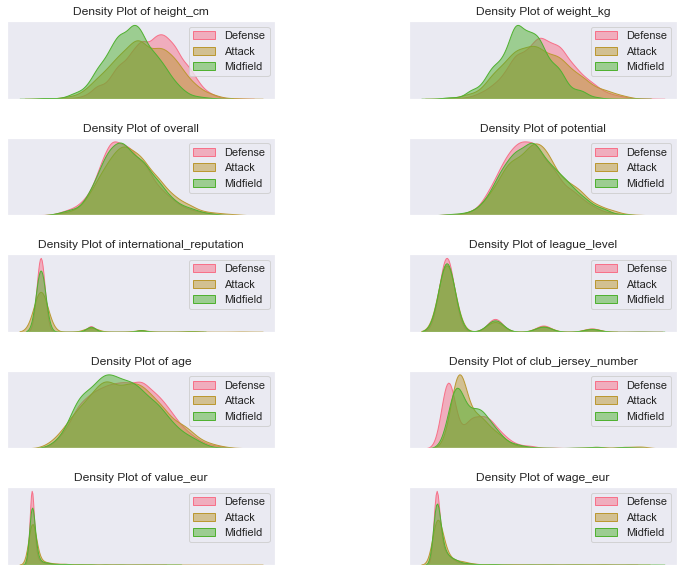

In [26]:
plot_hist_mult_h2(dk[po_1].iloc[:,1:],5,2,'job')

Insights: 
- Defenders and attackers are slightly taller and heavier than midfielders
    - Features: Weight and Height
- No other worthnote observation regarding the position location.

In [27]:
#Calculating CEF for position Side - left(L), Right(R), Center(C), Striker(S)
id_player2 = dk.groupby(['side'])[po_1].mean().sort_values(by='side_order',ascending=True).round(3).reset_index()
#Plot CEF Table
id_player2.T

,0,1,2,3
side,C,L,R,S
id,219681.268,225000.103,225953.769,219775.192
height_cm,180.816,180.463,180.419,183.988
weight_kg,74.854,74.37,74.568,78.745
overall,69.529,68.612,68.551,69.64
potential,72.553,71.914,71.913,72.082
international_reputation,1.194,1.138,1.123,1.248
league_level,1.396,1.359,1.359,1.348
age,28.312,27.901,27.749,28.624
club_jersey_number,15.348,16.846,16.368,19.042


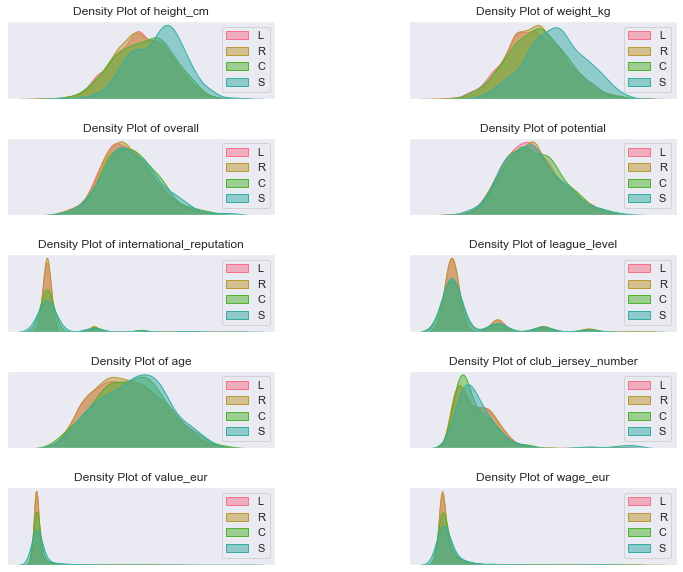

In [28]:
plot_hist_mult_h2(dk[po_1].iloc[:,1:],5,2,'side')

Insights: 
- No other worthnote observation regarding the position side.

In [29]:
#Calculating CEF for playing in bands
id_player3 = dk.groupby(['is_wing'])[po_1].mean().sort_values(by='is_wing',ascending=True).round(3).reset_index()
id_player3.T

,0,1
is_wing,no,yes
id,222479.173,228166.871
height_cm,182.452,177.536
weight_kg,76.461,71.745
overall,68.915,68.455
potential,72.052,71.88
international_reputation,1.159,1.119
league_level,1.366,1.355
age,28.242,27.357
club_jersey_number,16.108,17.624


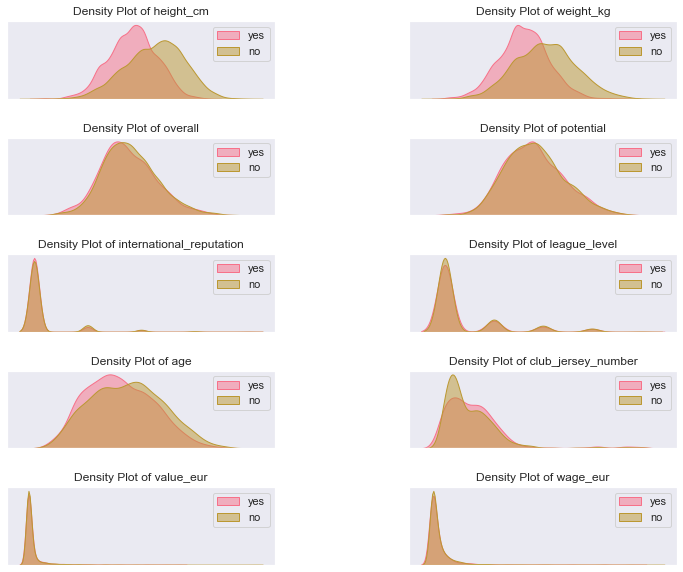

In [30]:
plot_hist_mult_h2(dk[po_1].iloc[:,1:],5,2,'is_wing')

Insights: 
- Those playing in the wings tend to be slightly shorter and thiner.
    - Features: Weight and Height
- No other worthnote observation about the position being wing or not.

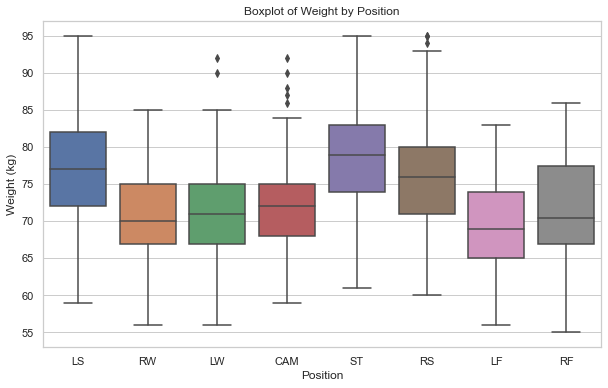

In [129]:
# Assuming 'position' is a categorical column in your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='position', y='weight_kg', data=dk[dk['job']=='Attack'])

# Set labels and title
plt.xlabel('Position')
plt.ylabel('Weight (kg)')
plt.title('Boxplot of Weight by Position')

# Show the plot
plt.show()


Insights:
Among all attacker positions, players occupying the foremost positions (ST, LS, RS) exhibit higher weights compared to other attacking positions.

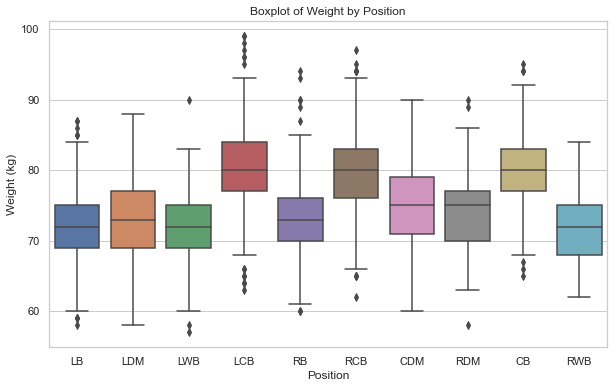

In [134]:
# Assuming 'position' is a categorical column in your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='position', y='weight_kg', data=dk[dk['job']=='Defense'])

# Set labels and title
plt.xlabel('Position')
plt.ylabel('Weight (kg)')
plt.title('Boxplot of Weight by Position')

# Show the plot
plt.show()

Insights:
Among all defender positions, players in the central back positions at the first defensive line (LCB, RCB, CB) tend to have higher weights compared to other defender positions. This pattern is often attributed to the typical characteristics of central backs, who are generally taller and stronger than players in other positions.

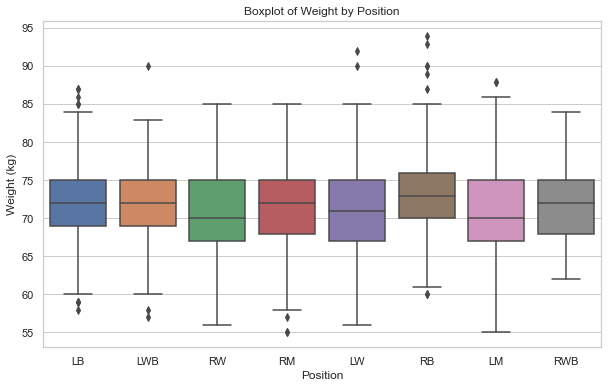

In [130]:
# Assuming 'position' is a categorical column in your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='position', y='weight_kg', data=dk[dk['is_wing']=='yes'])

# Set labels and title
plt.xlabel('Position')
plt.ylabel('Weight (kg)')
plt.title('Boxplot of Weight by Position')

# Show the plot
plt.show()

Insights:
- No major differences between wing positions.

### Studying player Skills (skill, high-level & mentality)

In [31]:
# List of variables to analyze
po_1 =['id','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control','skill_moves',
'pace','shooting','passing','dribbling','defending','physic','mentality_aggression','mentality_vision',
'mentality_composure','mentality_interceptions','mentality_positioning','mentality_penalties','job','job_order',
      'side','side_order','is_wing'
      ]
#Calculating CEF for position Location
id_player1 = dk.groupby(['job'])[po_1].mean().sort_values(by='job_order',ascending=True).round(3).reset_index()
#Plot CEF Table
id_player1.T

,0,1,2
job,Defense,Midfield,Attack
id,224310.966,226389.115,222708.338
skill_dribbling,56.986,67.925,69.148
skill_curve,47.563,60.301,60.099
skill_fk_accuracy,42.378,55.438,52.921
skill_long_passing,59.161,64.052,55.793
skill_ball_control,62.306,68.993,69.681
skill_moves,2.293,2.843,2.971
pace,65.237,70.99,72.701
shooting,44.916,60.244,67.316


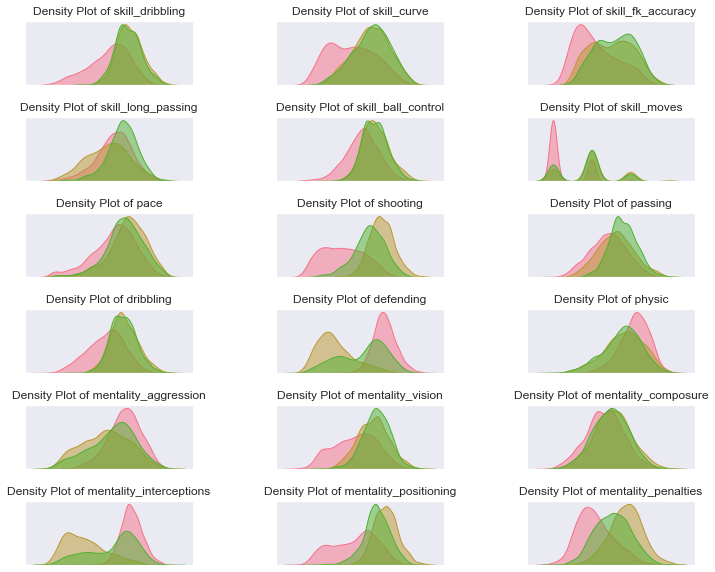

In [32]:
plot_hist_mult_h3(dk[po_1].iloc[:,1:],6,3,'job')

Insights:

Defenders generally exhibit lower ball control skills compared to attackers and midfielders, as reflected in their lower scores for shooting, accuracy, curve, and dribbling. However, they compensate for this by excelling in physical attributes, defending, and aggression. Conversely, there is a noticeable positive correlation between attackers and the mentality_penalty attribute.

In [33]:
#Calculating CEF for position Side
id_player2 = dk.groupby(['side'])[po_1].mean().sort_values(by='side_order',ascending=True).round(3).reset_index()
#Plot CEF Table
id_player2.T

,0,1,2,3
side,C,L,R,S
id,219681.268,225000.103,225953.769,219775.192
skill_dribbling,63.043,62.715,62.103,66.773
skill_curve,55.872,54.142,52.754,56.589
skill_fk_accuracy,52.808,48.526,47.0,48.516
skill_long_passing,64.555,60.02,59.657,49.942
skill_ball_control,67.163,65.595,65.263,68.645
skill_moves,2.683,2.586,2.567,2.752
pace,64.265,68.989,69.063,69.138
shooting,55.584,53.208,52.543,69.572


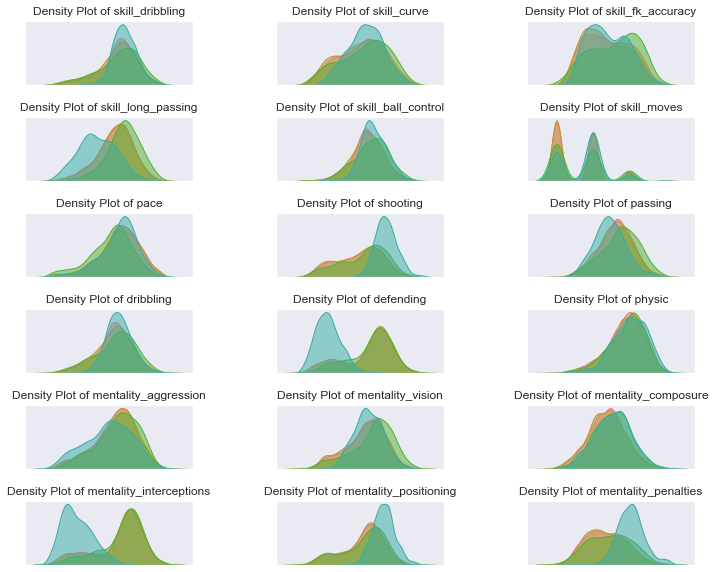

In [34]:
plot_hist_mult_h3(dk[po_1].iloc[:,1:],6,3,'side')

In [35]:
#Calculating CEF for playing in bands
id_player3 = dk.groupby(['is_wing'])[po_1].mean().sort_values(by='is_wing',ascending=True).round(3).reset_index()
id_player3.T

,0,1
is_wing,no,yes
id,222479.173,228166.871
skill_dribbling,60.651,66.685
skill_curve,51.686,58.025
skill_fk_accuracy,47.479,49.934
skill_long_passing,60.262,58.539
skill_ball_control,65.375,66.668
skill_moves,2.508,2.768
pace,64.494,75.98
shooting,53.934,54.975


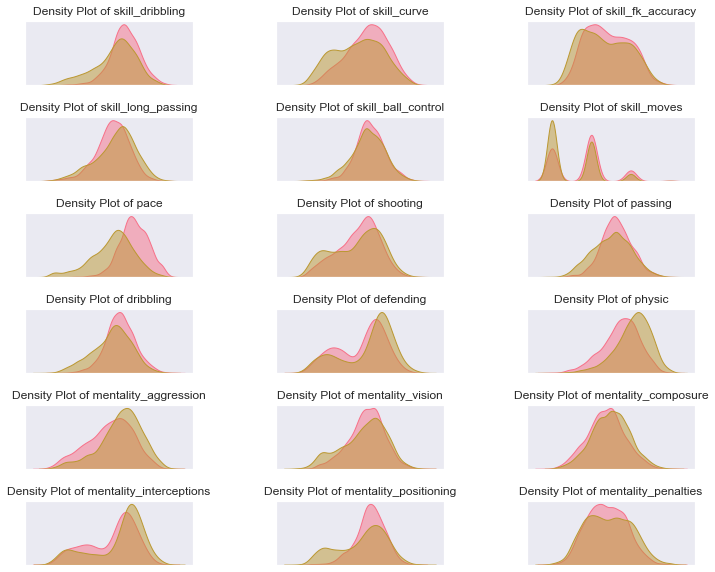

In [36]:
plot_hist_mult_h3(dk[po_1].iloc[:,1:],6,3,'is_wing')

Insights: 

An intriguing distinction in pace is observed between players in central positions and those on the wings, with the latter exhibiting higher speed when in possession of the ball.

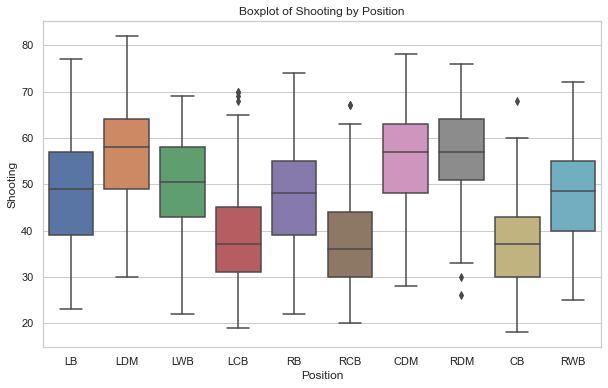

In [139]:
# Assuming 'position' is a categorical column in your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='position', y='shooting', data=dk[dk['job']=='Defense'])

# Set labels and title
plt.xlabel('Position')
plt.ylabel('Shooting')
plt.title('Boxplot of Shooting by Position')

# Show the plot
plt.show()

Insights: 
- From all defensive positions, we can see that those with the worse shooting skills are the central backs.
    - positions: LCB, RCB, CB
    - this would make sense since they tend to stay close to the goalkeeper area, not generating too many opportunities of goals in the rivals small area.

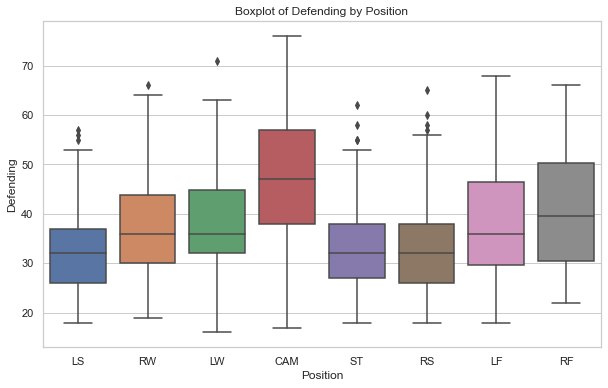

In [140]:
# Assuming 'position' is a categorical column in your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='position', y='defending', data=dk[dk['job']=='Attack'])

# Set labels and title
plt.xlabel('Position')
plt.ylabel('Defending')
plt.title('Boxplot of Defending by Position')

# Show the plot
plt.show()

Insights:
- From all our attacking positions, Those playing closer to Midfielders (CAM) have the highest defending scores.
    - CAM are those creating game between the midfield and the attackers.They are known for their assistances to the strikers and generating goal opportunities.

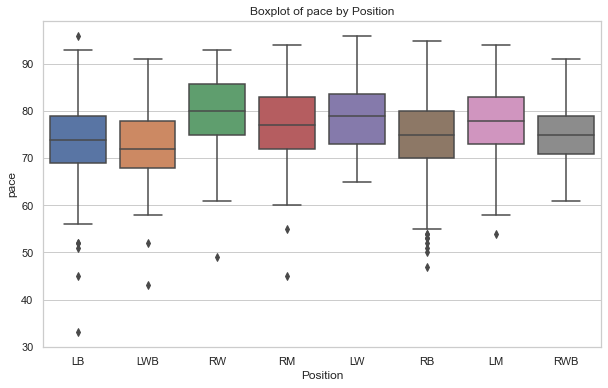

In [143]:
# Assuming 'position' is a categorical column in your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='position', y='pace', data=dk[dk['is_wing']=='yes'])

# Set labels and title
plt.xlabel('Position')
plt.ylabel('pace')
plt.title('Boxplot of pace by Position')

# Show the plot
plt.show()

Insights: 
- There are no major differences between wing positions. They all play with a similar pace.

### Studying player Skills 2 (Attack and movement)

In [47]:
po_2 = ['id','attacking_crossing','attacking_finishing','attacking_heading_accuracy',
'attacking_short_passing','attacking_volleys','movement_acceleration','movement_sprint_speed',
'movement_agility','movement_reactions','movement_balance','job','job_order','side','side_order','is_wing']
#Calculating CEF for position Location
id_player3 = dk.groupby('job')[po_2].mean().sort_values(by='job_order',ascending=True).round(3).reset_index()
#Plot CEF Table
id_player3.T

,0,1,2
job,Defense,Midfield,Attack
id,224310.966,226389.115,222708.338
attacking_crossing,53.813,61.852,57.201
attacking_finishing,40.393,58.547,68.329
attacking_heading_accuracy,61.676,53.154,60.46
attacking_short_passing,64.146,68.542,65.557
attacking_volleys,38.837,53.009,61.576
movement_acceleration,64.782,71.647,72.678
movement_sprint_speed,65.583,70.438,72.697
movement_agility,62.77,73.11,71.962


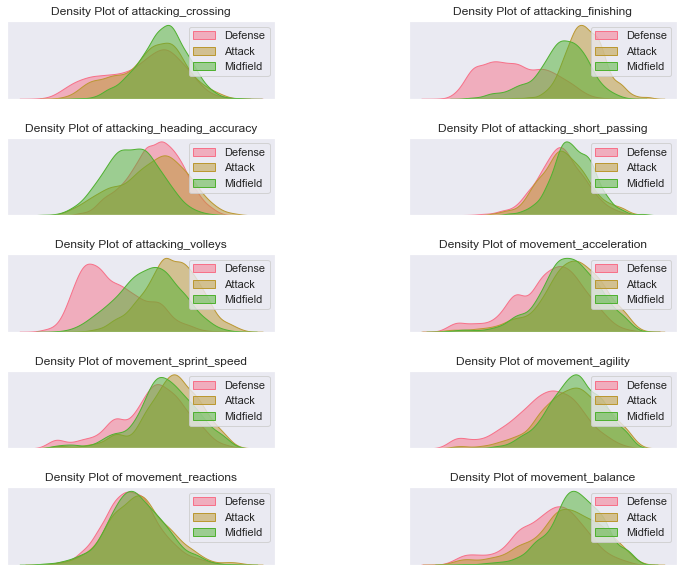

In [63]:
plot_hist_mult_h2(dk[po_2].iloc[:,1:],5,2,'job')

Insights:
Intriguing variations in attack metrics are evident across our three categories. Notably, the metrics of attacking_volleys and attacking_finishing prove effective in distinguishing between different positional locations.

In [51]:
#Calculating CEF for position Side
id_player2 = dk.groupby(['side'])[po_2].mean().sort_values(by='side_order',ascending=True).round(3).reset_index()
#Plot CEF Table
id_player2.T

,0,1,2,3
side,C,L,R,S
id,219681.268,225000.103,225953.769,219775.192
attacking_crossing,56.154,57.925,56.781,50.322
attacking_finishing,52.55,50.318,49.931,71.54
attacking_heading_accuracy,58.215,58.262,58.644,68.722
attacking_short_passing,68.431,65.553,65.399,63.432
attacking_volleys,48.971,46.866,46.132,64.612
movement_acceleration,64.832,69.0,68.921,68.217
movement_sprint_speed,63.79,68.964,69.144,69.888
movement_agility,67.232,68.106,67.616,66.374


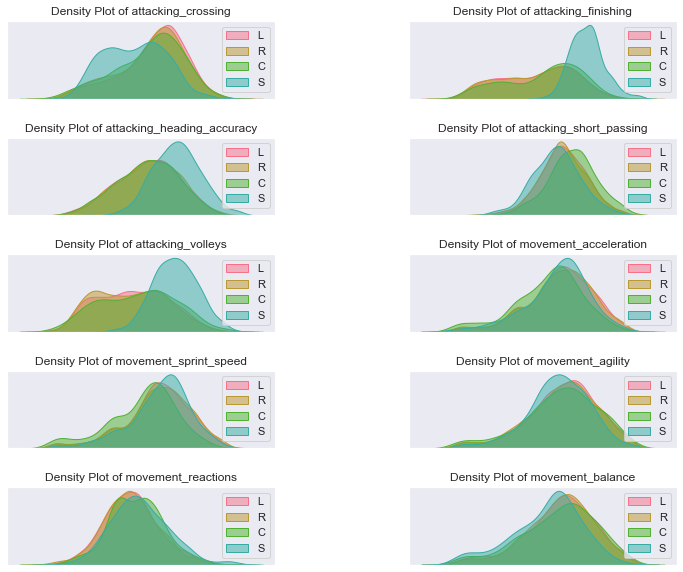

In [62]:
plot_hist_mult_h2(dk[po_2].iloc[:,1:],5,2,'side')

In [53]:
#Calculating CEF for playing in bands
id_player3 = dk.groupby(['is_wing'])[po_2].mean().sort_values(by='is_wing',ascending=True).round(3).reset_index()
id_player3.T

,0,1
is_wing,no,yes
id,222479.173,228166.871
attacking_crossing,52.417,64.723
attacking_finishing,51.22,52.986
attacking_heading_accuracy,62.061,53.731
attacking_short_passing,66.051,64.9
attacking_volleys,47.815,48.328
movement_acceleration,64.291,76.188
movement_sprint_speed,64.634,75.792
movement_agility,64.337,73.876


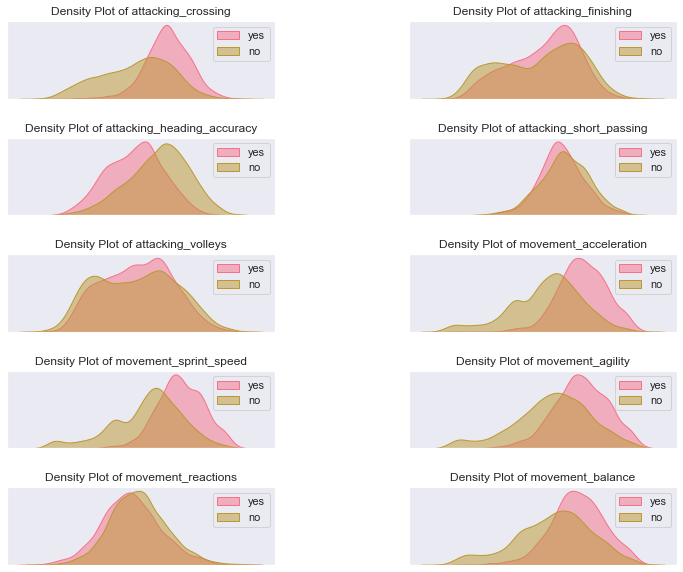

In [61]:
plot_hist_mult_h2(dk[po_2].iloc[:,1:],5,2,'is_wing')

Insights:
The disparities become more pronounced when examining metrics related to speed and agility.

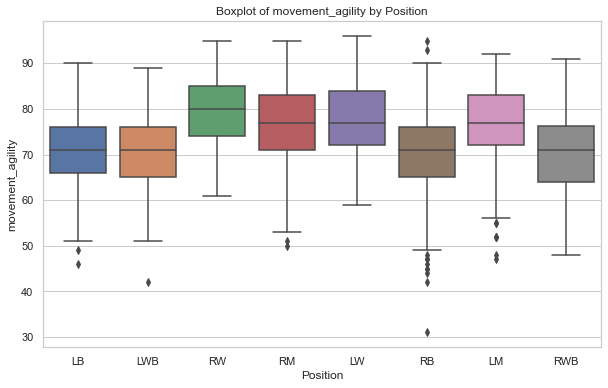

In [147]:
# Assuming 'position' is a categorical column in your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='position', y='movement_agility', data=dk[dk['is_wing']=='yes'])

# Set labels and title
plt.xlabel('Position')
plt.ylabel('movement_agility')
plt.title('Boxplot of movement_agility by Position')

# Show the plot
plt.show()

Insights:
Movement_agility serves as a valuable metric for distinguishing between attacking wings and defensive wings, with attacking wings displaying significantly higher agility scores.

### Studying player Skills 3 (Power and Defense)

In [57]:
po_3 = ['id','power_shot_power','power_jumping','power_stamina','power_strength',
'power_long_shots','defending_marking_awareness','defending_standing_tackle','defending_sliding_tackle'
       ,'job','job_order','side','side_order','is_wing']
#Calculating CEF for position Location
id_player3 = dk.groupby('job')[po_3].mean().sort_values(by='job_order',ascending=True).round(3).reset_index()
#Plot CEF Table
id_player3.T

,0,1,2
job,Defense,Midfield,Attack
id,224310.966,226389.115,222708.338
power_shot_power,55.585,65.618,69.822
power_jumping,70.549,64.101,67.076
power_stamina,71.826,73.023,69.29
power_strength,72.031,63.239,68.097
power_long_shots,44.634,60.696,64.265
defending_marking_awareness,65.516,52.708,34.979
defending_standing_tackle,67.451,54.083,34.46
defending_sliding_tackle,65.291,50.892,30.943


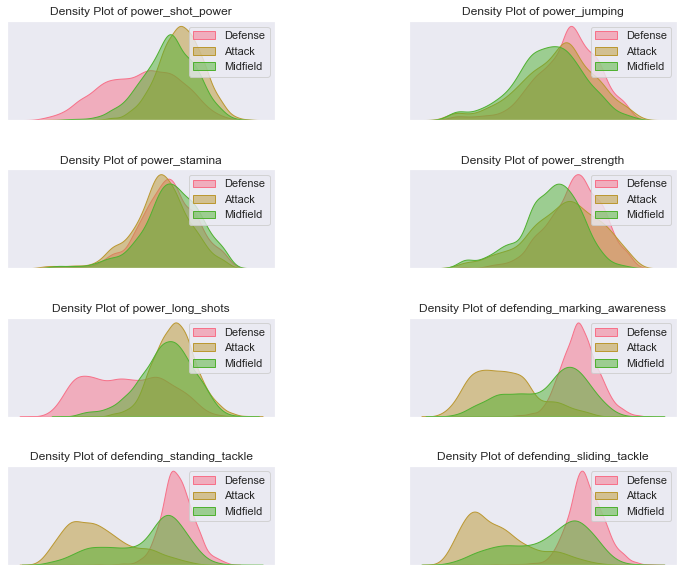

In [60]:
plot_hist_mult_h2(dk[po_3].iloc[:,1:],4,2,'job')

Insights:
- defending awareness, defending_standing_tackle and sliding seem to show large differences between position location and within Midfielder positions

In [64]:
#Calculating CEF for position Side
id_player2 = dk.groupby(['side'])[po_3].mean().sort_values(by='side_order',ascending=True).round(3).reset_index()
#Plot CEF Table
id_player2.T

,0,1,2,3
side,C,L,R,S
id,219681.268,225000.103,225953.769,219775.192
power_shot_power,63.096,60.966,60.245,71.729
power_jumping,66.849,67.844,67.997,70.958
power_stamina,71.974,71.597,71.918,68.243
power_strength,68.892,67.911,68.464,75.591
power_long_shots,56.453,52.876,51.72,64.315
defending_marking_awareness,58.091,56.29,56.713,30.112
defending_standing_tackle,59.645,57.678,58.044,28.89
defending_sliding_tackle,56.319,55.265,55.302,24.853


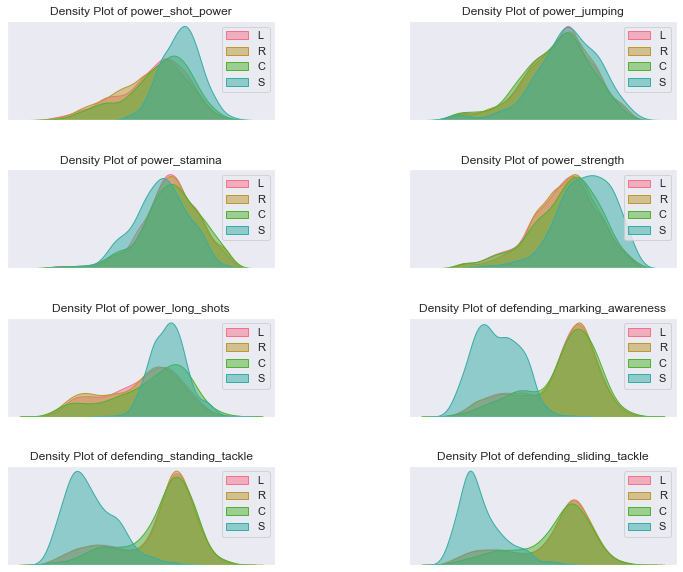

In [65]:
plot_hist_mult_h2(dk[po_3].iloc[:,1:],4,2,'side')

In [66]:
#Calculating CEF for playing in bands
id_player3 = dk.groupby(['is_wing'])[po_3].mean().sort_values(by='is_wing',ascending=True).round(3).reset_index()
id_player3.T

,0,1
is_wing,no,yes
id,222479.173,228166.871
power_shot_power,61.971,60.992
power_jumping,69.152,65.923
power_stamina,71.001,72.534
power_strength,72.0,62.813
power_long_shots,53.195,54.216
defending_marking_awareness,56.101,52.588
defending_standing_tackle,57.343,53.72
defending_sliding_tackle,54.133,51.803


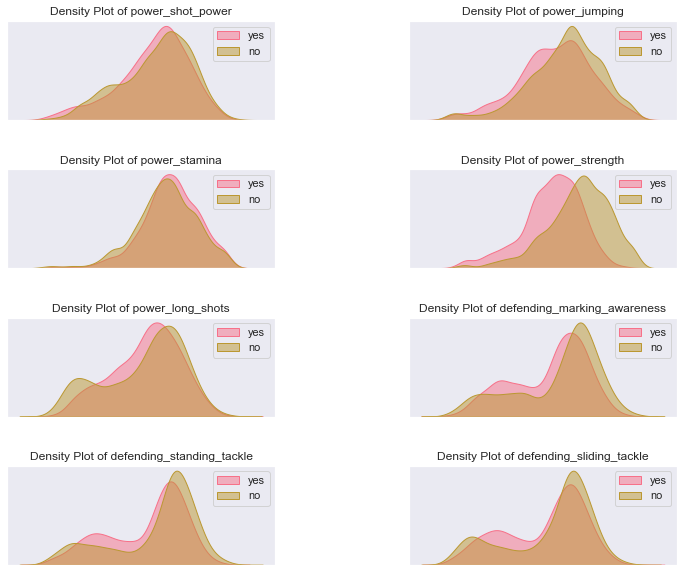

In [68]:
plot_hist_mult_h2(dk[po_3].iloc[:,1:],4,2,'is_wing')

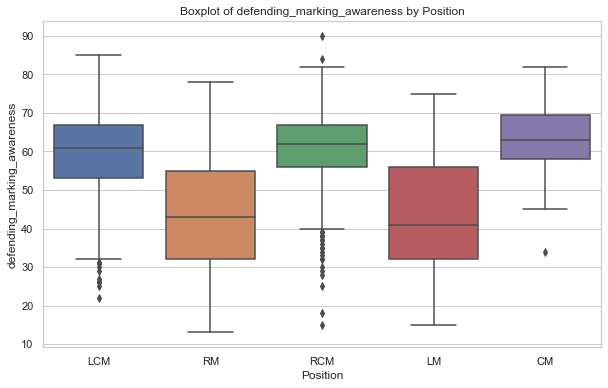

In [148]:
# Assuming 'position' is a categorical column in your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='position', y='defending_marking_awareness', data=dk[dk['job']=='Midfield'])

# Set labels and title
plt.xlabel('Position')
plt.ylabel('defending_marking_awareness')
plt.title('Boxplot of defending_marking_awareness by Position')

# Show the plot
plt.show()

Insights:
In this scenario, it is evident that CM, LCM, and RCM positions boast the highest defense scores. This aligns with their strategic role on the field, focusing on ball recovery to initiate attacks alongside attacking midfielders.

## 3. Addressing Outliers and Unique Values 

In [64]:
def plot_boxplots(data, variables, plots_per_row=2):
    num_variables = len(variables)
    num_rows = math.ceil(num_variables / plots_per_row)

    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(12, 4 * num_rows))
    fig.subplots_adjust(hspace=0.5)

    for i, variable in enumerate(variables):
        row, col = divmod(i, plots_per_row)
        ax = axes[row, col] if num_rows > 1 else axes[col]

        ax.boxplot(data[variable])
        ax.set_title(f'Boxplot of {variable}')
        ax.set_ylabel(variable)

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    plt.show()

In [65]:
# Types of Variables 

# Numerical Variables 
num_vars = ['id',  'overall', 'potential', 'value_eur', 'wage_eur',
       'height_cm', 'weight_kg',
       'league_level', 'club_jersey_number', 
       'club_contract_valid_until',
       'weak_foot', 'skill_moves',
       'international_reputation', 
       'release_clause_eur', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

# Non-numerical Variables 
non_num_vars = ['birthday_date', 'position', 'short_name', 'birthday_date', 'club_name', 'league_name', 'nationality_name', 'preferred_foot', 'work_rate', 'body_type', 'real_face', 'player_traits', ]

##### Checking for outliers in the numerical variables 

Although, there are outliers non will be removed through winsorizing the data. The outliers provide a lot of information for certain positions and roles of players that would otherwise be lost if removed. 

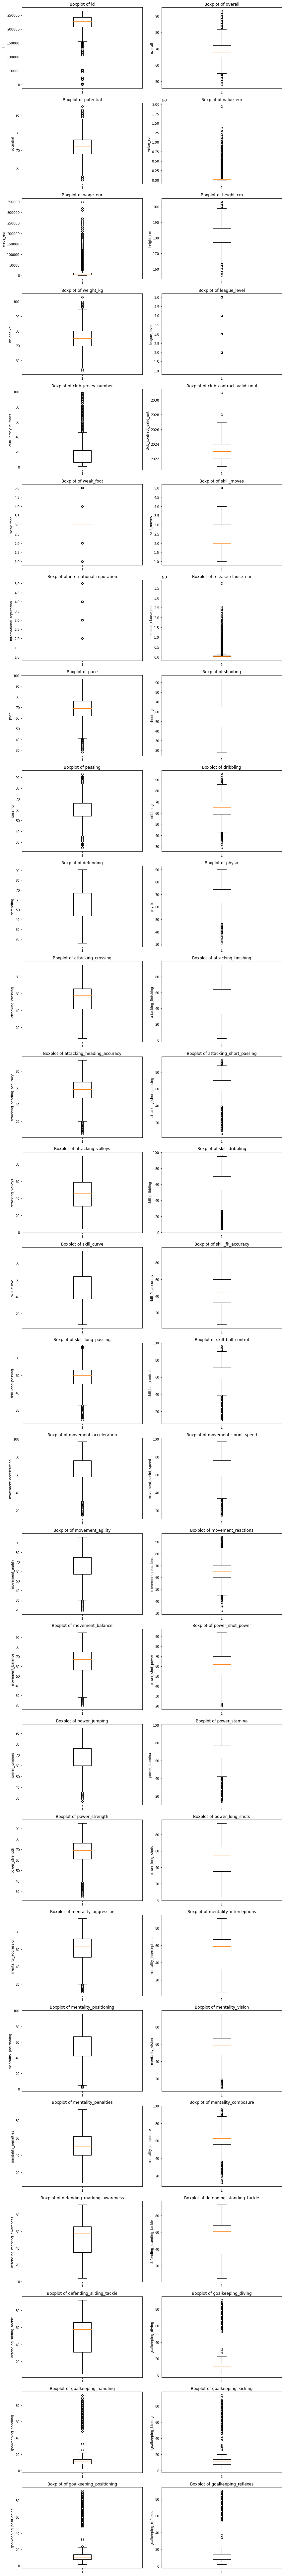

In [66]:
# Execute Boxplots for numerical variables 
columns = num_vars
plot_boxplots(df, columns, plots_per_row=2)

##### Correlation Matrix for Numerical Variables 

This allows us to check if there is any strong relationship/correlation between any of the numerical variables, if there are any issues of multicolinearity that need to be resolved.  

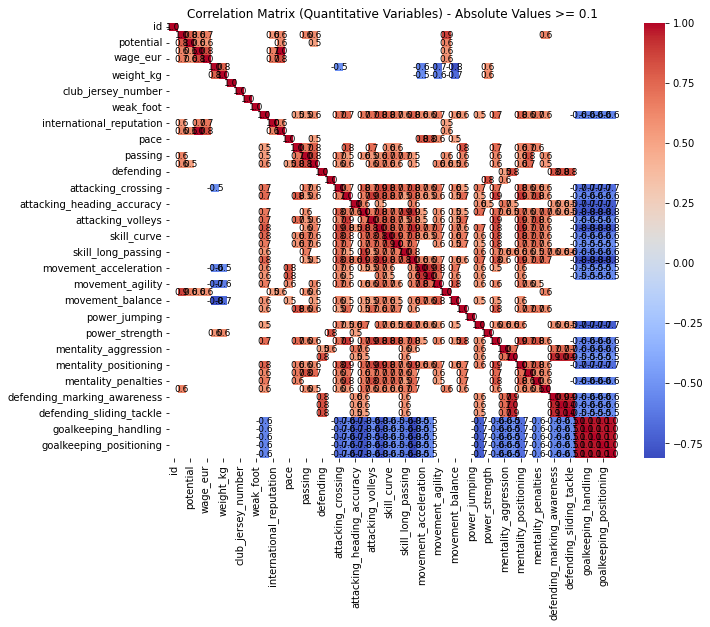

In [67]:
# Correlations among the variables with abs(correlation) >= 0.1
df_for_heatmap = df[['id',  'overall', 'potential', 'value_eur', 'wage_eur',
       'height_cm', 'weight_kg',
       'league_level', 'club_jersey_number', 
       'club_contract_valid_until',
       'weak_foot', 'skill_moves',
       'international_reputation', 
       'release_clause_eur', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']]
df_for_heatmap_corr = df_for_heatmap.corr()

# Filter correlations with abs(correlation) >= 0.1
mask = (df_for_heatmap_corr.abs() >= 0.5)
df_for_heatmap_corr_filtered = df_for_heatmap_corr[mask]

# Plot correlations with adjusted font size and text color
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(df_for_heatmap_corr_filtered, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 9, "color": "black"})
plt.title('Correlation Matrix (Quantitative Variables) - Absolute Values >= 0.1')
plt.show()

Correlation Matrix:

We observe several correlations among our features. It's important to note that our model, specifically a random forest classifier, is resilient to issues of collinearity. This is particularly advantageous when dealing with extensive datasets characterized by a substantial number of columns. The random forest classifier's robustness against colinearity contributes to its effectiveness, making it well-suited for handling large and complex datasets.

In [68]:
# Custom function to calculate the number of unique values for given columns
def calculate_unique_counts(dataframe, columns):
    unique_counts = {}
    for column in columns:
        unique_count = dataframe[column].nunique()
        unique_counts[column] = unique_count
    return unique_counts

# List of columns to calculate unique counts
columns_to_check = non_num_vars

# Calculate unique counts for the specified columns
unique_counts = calculate_unique_counts(df, columns_to_check)

# Print the results
for column, count in unique_counts.items():
    print(f"Number of unique values in {column}: {count}")

Number of unique values in birthday_date: 4214
Number of unique values in position: 24
Number of unique values in short_name: 7418
Number of unique values in club_name: 701
Number of unique values in league_name: 55
Number of unique values in nationality_name: 144
Number of unique values in preferred_foot: 2
Number of unique values in work_rate: 9
Number of unique values in body_type: 10
Number of unique values in real_face: 2
Number of unique values in player_traits: 825


In [69]:
# Unique values for strings
def calculate_value_counts(df, columns, top_n=10):
    
    for column in columns:
        # Calculate the count of each unique value
        value_counts = df[column].value_counts()

        # Calculate the percentage of each unique value
        percentage = (value_counts / len(df)) * 100

        # Create a new DataFrame to display the results
        result_df = pd.DataFrame({column: value_counts.index, 'Count': value_counts, 'Percentage': percentage})

        # Display the top values
        print(result_df.head(top_n))

# Example usage with multiple columns
columns = ['preferred_foot', 'work_rate', 'body_type', 'real_face']
calculate_value_counts(df, columns, top_n=10)

      preferred_foot  Count  Percentage
Right          Right   5779   75.424171
Left            Left   1883   24.575829
                   work_rate  Count  Percentage
Medium/Medium  Medium/Medium   3477   45.379796
High/Medium      High/Medium   1635   21.339076
Medium/High      Medium/High    944   12.320543
High/High          High/High    592    7.726442
High/Low            High/Low    326    4.254764
Medium/Low        Medium/Low    276    3.602193
Low/High            Low/High    217    2.832159
Low/Medium        Low/Medium    181    2.362307
Low/Low              Low/Low     14    0.182720
                         body_type  Count  Percentage
Normal (170-185)  Normal (170-185)   2758   35.995824
Normal (185+)        Normal (185+)   1810   23.623075
Lean (170-185)      Lean (170-185)   1400   18.271992
Lean (185+)            Lean (185+)    702    9.162099
Normal (170-)        Normal (170-)    276    3.602193
Stocky (170-185)  Stocky (170-185)    256    3.341164
Stocky (185+)        S

In [70]:
# Unique values for player_traits
columns = ['player_traits']
calculate_value_counts(df, columns, top_n=50)

                                                                                        player_traits  \
Speed Dribbler (AI)                                                               Speed Dribbler (AI)   
Power Header                                                                             Power Header   
Dives Into Tackles (AI)                                                       Dives Into Tackles (AI)   
Long Passer (AI)                                                                     Long Passer (AI)   
Long Shot Taker (AI)                                                             Long Shot Taker (AI)   
Injury Prone                                                                             Injury Prone   
Technical Dribbler (AI)                                                       Technical Dribbler (AI)   
Leadership                                                                                 Leadership   
Early Crosser                                          

#### Encoding Unique Values 

##### OneHotEncoding on the body_type & preferred_foot columns 

Body_type encoding: In order to properly use this unique value, we first will be remocing the unnecessary information such as the different weight ranges and just keeping the word descriptions such as Normal, Lean, Stocky, etc so its more useful to encode. Then created dummies for both the body_type column and preferred_foot column.  

In [71]:
# Dealing with body_type
# body_type values                                           
# Normal (170-185)  Normal (170-185)   1409   37.643601
# Lean (170-185)      Lean (170-185)    768   20.518301
# Normal (185+)        Normal (185+)    711   18.995458
# Lean (185+)            Lean (185+)    268    7.160032
# Normal (170-)        Normal (170-)    168    4.488378
# Stocky (170-185)  Stocky (170-185)    148    3.954048
# Lean (170-)            Lean (170-)     87    2.324339
# Unique                      Unique     76    2.030457
# Stocky (185+)        Stocky (185+)     73    1.950307
# Stocky (170-)        Stocky (170-)     35    0.935079
# As far as we already have height, we'll replace values with Normal/Lean/Stocky/Unique and then create dummies

# Replace values with the word before parenthesis
df['body_type'] = df['body_type'].str.extract(r'(\w+)\s*\(')

# Keep "Unique" if it is present in the original column
df.loc[df['body_type'].isna(), 'body_type'] = 'Unique'

# Display the resulting DataFrame
print(df.head())

       id   short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302    E. García       71         71  1400000.0     10000    1989-12-28   
1  237867   D. Cancola       65         71  1000000.0      2000    1996-10-23   
2  253472      E. Kahl       65         77  1600000.0      2000    2001-09-27   
3  223994    S. Mugoša       72         72  2300000.0      5000    1992-02-26   
4  251635  A. Țigănașu       65         65   525000.0      3000    1990-06-12   

   height_cm  weight_kg                  club_name  ...      today  age  \
0        176         73  Club Atlético de San Luis  ... 2022-11-01   32   
1        183         73             Ross County FC  ... 2022-11-01   26   
2        178         69                  Aarhus GF  ... 2022-11-01   21   
3        188         81          Incheon United FC  ... 2022-11-01   30   
4        179         74                FC Botoşani  ... 2022-11-01   32   

   years_in_club      job position_line position_loc  is_wing 

In [72]:
# Function to create dummies
def one_hot(df, columns):
    dummy = pd.get_dummies(df[columns])
    encoded_df = pd.concat([df, dummy], axis=1)
    return encoded_df

# Columns to create dummies for
columns_to_encode = ['preferred_foot', 'body_type']

# Apply the one_hot function
df = one_hot(df, columns_to_encode)

# Drop the original columns after creating dummies
df = df.drop(columns=columns_to_encode)

# Display the resulting DataFrame
print(df.head())

       id   short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302    E. García       71         71  1400000.0     10000    1989-12-28   
1  237867   D. Cancola       65         71  1000000.0      2000    1996-10-23   
2  253472      E. Kahl       65         77  1600000.0      2000    2001-09-27   
3  223994    S. Mugoša       72         72  2300000.0      5000    1992-02-26   
4  251635  A. Țigănașu       65         65   525000.0      3000    1990-06-12   

   height_cm  weight_kg                  club_name  ... is_wing  \
0        176         73  Club Atlético de San Luis  ...     yes   
1        183         73             Ross County FC  ...      no   
2        178         69                  Aarhus GF  ...     yes   
3        188         81          Incheon United FC  ...      no   
4        179         74                FC Botoşani  ...     yes   

   position_line_ord  job_order  side preferred_foot_Left  \
0                  1          1     L            

##### Label Encoding in the work_rate Column 

In [73]:
# Dealing with work_rate                                      
# Medium/Medium Medium/Medium   1231   32.888058
# High/Medium      High/Medium   1005   26.850120
# Medium/High      Medium/High    511   13.652151
# High/High          High/High    409   10.927064
# High/Low            High/Low    215    5.744056
# Medium/Low        Medium/Low    170    4.541811
# Low/High            Low/High    118    3.152551
# Low/Medium        Low/Medium     76    2.030457
# Low/Low              Low/Low      8    0.213732
# Function to create "Attacking" and "Defensive" columns
def split_work_rate(df, column_name):
    # Split the values in the column by '/'
    split_values = df[column_name].str.split('/', expand=True)

    # Create new columns "Attacking" and "Defensive"
    df['Attacking'] = split_values[0]
    df['Defensive'] = split_values[1]

    # Drop the original "work_rate" column
    df = df.drop(column_name, axis=1)

    return df

# Apply the function to your DataFrame
df = split_work_rate(df, 'work_rate')

In [74]:
# Function for label encoding
def label_encode(df, columns):
    label_mapping = {'High': 3, 'Medium': 2, 'Low': 1}

    for column in columns:
        # Use map function to replace values based on the label_mapping dictionary
        df[column] = df[column].map(label_mapping)

    return df

# Apply label encoding to "Attacking" and "Defensive" columns
columns_to_encode = ['Attacking', 'Defensive']
df = label_encode(df, columns_to_encode)

# Display the resulting DataFrame
#print(df.head(1))

##### Dummies for player_traits 

In [75]:
# The (AI) on the player_traits variable is to differentiate between the video game and real players, 
#we will be creationg function to remove (AI) from the column 

def remove_ai(df, column):
    df[column] = df[column].str.replace(r'\s*\([^)]*\)', '', regex=True)
    return df

# Column to process
column = 'player_traits'

# Apply the function
df = remove_ai(df, column)

# Display the resulting DataFrame
print(df.head())

       id   short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302    E. García       71         71  1400000.0     10000    1989-12-28   
1  237867   D. Cancola       65         71  1000000.0      2000    1996-10-23   
2  253472      E. Kahl       65         77  1600000.0      2000    2001-09-27   
3  223994    S. Mugoša       72         72  2300000.0      5000    1992-02-26   
4  251635  A. Țigănașu       65         65   525000.0      3000    1990-06-12   

   height_cm  weight_kg                  club_name  ... job_order  side  \
0        176         73  Club Atlético de San Luis  ...         1     L   
1        183         73             Ross County FC  ...         1     L   
2        178         69                  Aarhus GF  ...         1     L   
3        188         81          Incheon United FC  ...         3     L   
4        179         74                FC Botoşani  ...         1     L   

   preferred_foot_Left  preferred_foot_Right body_type_Lean  b

In [76]:
# Ensure all values are strings and split each entry into a list of traits
traits_lists = [str(value).split(', ') if pd.notna(value) else [] for value in df['player_traits']]

# Flatten the list of lists
all_traits = [trait for sublist in traits_lists for trait in sublist]

# Create a set to get unique traits
unique_traits_set = set(all_traits)

# Convert the set to a list
unique_traits_list = list(unique_traits_set)

# Calculate the length of the list
list_length = len(unique_traits_list)

# Display the list of unique traits and its length
print("Unique Traits:", unique_traits_list)
print("Length of Unique Traits List:", list_length)

Unique Traits: ['Outside Foot Shot', 'Dives Into Tackles', 'Power Header', 'Solid Player', 'Long Shot Taker', 'Long Passer', 'One Club Player', 'Power Free-Kick', 'GK Long Throw', 'Speed Dribbler', 'Technical Dribbler', 'Playmaker', 'Early Crosser', 'Cautious With Crosses', 'Long Throw-in', 'Leadership', 'Saves with Feet', 'Injury Prone', 'Chip Shot', 'Flair', 'Rushes Out Of Goal', 'Finesse Shot', 'Comes For Crosses', 'Team Player', 'Giant Throw-in']
Length of Unique Traits List: 25


In [77]:
# Create dummy variables for each unique trait
for trait in unique_traits_list:
    df[trait] = df['player_traits'].apply(lambda x: 1 if trait in str(x) else 0)

# Display the resulting DataFrame
print(df.head())

       id   short_name  overall  potential  value_eur  wage_eur birthday_date  \
0  216302    E. García       71         71  1400000.0     10000    1989-12-28   
1  237867   D. Cancola       65         71  1000000.0      2000    1996-10-23   
2  253472      E. Kahl       65         77  1600000.0      2000    2001-09-27   
3  223994    S. Mugoša       72         72  2300000.0      5000    1992-02-26   
4  251635  A. Țigănașu       65         65   525000.0      3000    1990-06-12   

   height_cm  weight_kg                  club_name  ... Leadership  \
0        176         73  Club Atlético de San Luis  ...          0   
1        183         73             Ross County FC  ...          0   
2        178         69                  Aarhus GF  ...          0   
3        188         81          Incheon United FC  ...          0   
4        179         74                FC Botoşani  ...          0   

   Saves with Feet  Injury Prone  Chip Shot Flair  Rushes Out Of Goal  \
0                0 

## 4. Standarize Columns 

During standardization we are subtracting the mean and diving by its standard deviation. The goal of the standardization is to have a similar scale between different variables so that those with higher magnitudes don't overpower/ dominated other features. 

During the Standardization of our data we see that our values change but it does not seem to have a mayor impact on the overall performance of our model. But although there seems to not be mayor changes to our model performance, we have still kept the standardization as there are might be small less visible impacts that we might not be accounting for. 

In [78]:
# Function to standardise values (but actually it doesn't change the accuracy of the model of ROC AUC)
def standardize(df, columns):
    for column in columns:
        df[column + '_standardized'] = (df[column] - df[column].mean()) / df[column].std()
        
    # Drop the original columns
    df.drop(columns=columns, inplace=True)
    return df

columns_to_standardize = ['value_eur', 'wage_eur', 'release_clause_eur']
df = standardize(df, columns_to_standardize)
df.columns.to_list()

['id',
 'short_name',
 'overall',
 'potential',
 'birthday_date',
 'height_cm',
 'weight_kg',
 'club_name',
 'league_name',
 'league_level',
 'club_jersey_number',
 'club_contract_valid_until',
 'nationality_name',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'real_face',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awarene

## 5. Train & Test Models 

##### Split the data back to train and test in order to train the model 

In [79]:
# Divide train and test datasets
df_train = df[df['is_test'] == 0]
df_test = df[df['is_test'] == 1]

In [80]:
# Check the shape
print(df_train.shape)
print(df_test.shape)

(6895, 107)
(767, 107)


In [81]:
# Check the columns
column_names = df.columns.tolist()
print(column_names)

['id', 'short_name', 'overall', 'potential', 'birthday_date', 'height_cm', 'weight_kg', 'club_name', 'league_name', 'league_level', 'club_jersey_number', 'club_contract_valid_until', 'nationality_name', 'weak_foot', 'skill_moves', 'international_reputation', 'real_face', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_slidi

In [82]:
# Create a list for feature columns
lists = ['id', 'overall', 'potential', 'height_cm', 'weight_kg', 'club_jersey_number', 'club_contract_valid_until', 'weak_foot', 'skill_moves', 'international_reputation', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed', 'position', 'age', 'years_in_club', 'preferred_foot_Left', 'preferred_foot_Right', 'body_type_Lean', 'body_type_Normal', 'body_type_Stocky', 'body_type_Unique', 'Attacking', 'Defensive', 'Technical Dribbler', 'Early Crosser', 'Solid Player', 'Giant Throw-in', 'Saves with Feet', 'Long Passer', 'Injury Prone', 'Leadership', 'GK Long Throw', 'Chip Shot', 'Long Throw-in', 'Playmaker', 'Rushes Out Of Goal', 'Outside Foot Shot', 'Flair', 'Dives Into Tackles', 'Power Header', 'Comes For Crosses', 'Speed Dribbler', 'Power Free-Kick', 'Team Player', 'Cautious With Crosses', 'Long Shot Taker', 'One Club Player', 'Finesse Shot', 'value_eur_standardized', 'wage_eur_standardized', 'release_clause_eur_standardized']

In [83]:
# Define train and test datasets (only features needed and no target variable in the test)
df_t = df_test[lists]
df_t = df_t.drop('position',axis=1)
df_tr = df_train[lists]

##### Split Data (Train/Test)

Important to note that the data was split into 80% train and 20% test 

In [84]:
# Split train dataset
# df_tr is our dataframe and 'position' is the target variable
X = df_tr.drop('position', axis=1)  # Features
y = df_tr['position']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [85]:
# keep id for submission
df_test_id = df_test[['id']]

#### Unbalanced Dataset 

A potential problem with the dataset is the issue of imbalanced classification, so there are few too many examples of the minority class for a model to effectively learn the decision boundary. One way to solve an issue of unbalance is to oversample in the minority class. This is done by duplicating examples from the minority class in the training dataset prior to fitting a model. This helps balance the class distribution but does not provide additional information to the model. For our models, we used SMOTE to deal with the potential issue of unbalanced dataset. 

After testing the model using the synthetic minority over-sampling technique (SMOTE) on our models, we noticed that it lowered our score so we decided to leave it out of the final submission. Our better performing model is the RandomForest which is an ensemble model that is less sensitive to class imbalances compared to some other algorithms. So using the SMOTE might be disrupting the balanace achieved by the RandomForest which could potentially be the cause of the suboptimal performance score. 

In [86]:
# Generate new synthetic data for minority class using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### CatBoost Classifier 

In [ ]:
# Drop 'id' column from X_train and X_test
X_train_no_id = X_train.drop('id', axis=1)
X_test_no_id = X_test.drop('id', axis=1)

# Define the hyperparameter search space
param_dist = {
    'iterations': randint(50, 200),
    'depth': randint(4, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Initialize a CatBoost classifier
catboost_classifier = CatBoostClassifier(random_state=1, verbose=0)

# Create the randomized search object
random_search = RandomizedSearchCV(
    catboost_classifier,
    param_distributions=param_dist,
    n_iter=10,  # You can adjust this depending on your computational resources
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',
    random_state=1,
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the randomized search to the training data
random_search.fit(X_train_no_id, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions on the test set with the best model
y_pred_random_search = random_search.predict(X_test_no_id)

# Calculate accuracy on the test set
accuracy_random_search = accuracy_score(y_test, y_pred_random_search)
print("Accuracy with Best Hyperparameters:", accuracy_random_search)

##### Metrics Calculation for Catboost Classifier

In [ ]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_random_search, average='weighted')
recall = recall_score(y_test, y_pred_random_search, average='weighted')
f1 = f1_score(y_test, y_pred_random_search, average='weighted')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1)

##### AUC Score for Catboost Classifier 

In [ ]:
# Make predictions on the test set with the best model
y_prob = random_search.predict_proba(X_test_no_id)

# Binarize the labels for each class
y_test_bin = label_binarize(y_test, classes=random_search.classes_)

# Calculate ROC AUC for each class
auc_scores = []
for i in range(len(random_search.classes_)):
    auc_score = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
    auc_scores.append(auc_score)
    print(f"Class {random_search.classes_[i]} - AUC Score: {auc_score:.2f}")

# Micro-average ROC AUC
micro_auc = roc_auc_score(y_test_bin, y_prob, average='micro')
print(f"Micro-average AUC Score: {micro_auc:.2f}")

# Macro-average ROC AUC
macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro')
print(f"Macro-average AUC Score: {macro_auc:.2f}")

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(random_search.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {random_search.classes_[i]} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()

### Random Forest Classifier

In [87]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize a random forest classifier
rf_classifier = RandomForestClassifier(random_state=1)

# Create the GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Best Parameters:", accuracy)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy with Best Parameters: 0.4474256707759246


##### Metrics Calculation for Random Forest Classifier

In [88]:
# Calculate all evaluation metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1 Score:", f1)

Weighted Precision: 0.35913358922865773
Weighted Recall: 0.4474256707759246
Weighted F1 Score: 0.38367546033270883


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### AUC Score for Random Forest Classifier 

Class CAM - AUC Score: 0.90
Class CB - AUC Score: 0.92
Class CDM - AUC Score: 0.88
Class CM - AUC Score: 0.82
Class GK - AUC Score: 1.00
Class LB - AUC Score: 0.97
Class LCB - AUC Score: 0.92
Class LCM - AUC Score: 0.88
Class LDM - AUC Score: 0.89
Class LF - AUC Score: 0.86
Class LM - AUC Score: 0.87
Class LS - AUC Score: 0.91
Class LW - AUC Score: 0.90
Class LWB - AUC Score: 0.94
Class RB - AUC Score: 0.96
Class RCB - AUC Score: 0.94
Class RCM - AUC Score: 0.87
Class RDM - AUC Score: 0.89
Class RF - AUC Score: 0.87
Class RM - AUC Score: 0.88
Class RS - AUC Score: 0.92
Class RW - AUC Score: 0.93
Class RWB - AUC Score: 0.92
Class ST - AUC Score: 0.98
Micro-average AUC Score: 0.94
Macro-average AUC Score: 0.91


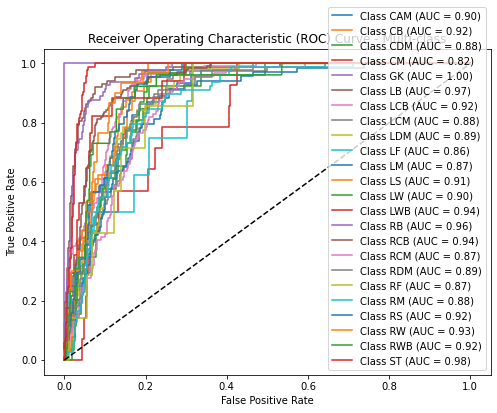

In [89]:
# Predict probabilities for each class
y_prob = best_rf_classifier.predict_proba(X_test)

# Binarize the labels for each class
y_test_bin = label_binarize(y_test, classes=best_rf_classifier.classes_)

# Calculate ROC AUC for each class
auc_scores = []
for i in range(len(best_rf_classifier.classes_)):
    auc_score = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
    auc_scores.append(auc_score)
    print(f"Class {best_rf_classifier.classes_[i]} - AUC Score: {auc_score:.2f}")

# Micro-average ROC AUC
micro_auc = roc_auc_score(y_test_bin, y_prob, average='micro')
print(f"Micro-average AUC Score: {micro_auc:.2f}")

# Macro-average ROC AUC
macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro')
print(f"Macro-average AUC Score: {macro_auc:.2f}")

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(best_rf_classifier.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {best_rf_classifier.classes_[i]} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()

##### Cross-Validation for Models

Cross-validation allows us to evaluate the performance of a model on unseen data. It parts the available dataset into multiple different subsets or folds, and each fold is used as training and validating data in different iterations.

Using the the k-fold cross validation, it divides the datset into k equally sized folds. It trains our model and evaluates it k times, and uses a different fold as the validation set and the remaining folds as the training set. The k-fold is useful for dataset is large, which in our case it is fairly big with several categories and is useful hyperparameter tunning and model evaluation. 

The Stratified cross-validation is really useful for datset that are imbalanced or when class labels need to be represented equally in each fold. This cross-validation ensures similar proportion from each class of the original dataset. Our model seems to potentially have unbalanced classes so using this cross-validation ensures that we account for that inbalance.

In [93]:
# Function to evaluate model and measure time
def evaluate_model_with_time(model, X, y, cv):
    start_time = time.time()
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return scores.mean(), elapsed_time

# Initialize the models
catboost_classifier = CatBoostClassifier(random_state=1, verbose=0)
rf_classifier = RandomForestClassifier(random_state=1)

# Create a dictionary to store the results and time spent
results_catboost = {}
results_rf = {}
times_catboost = {}
times_rf = {}

# Method 1: No cross-validation
results_catboost['No CV'], times_catboost['No CV'] = evaluate_model_with_time(catboost_classifier, X_train, y_train, cv=None)
results_rf['No CV'], times_rf['No CV'] = evaluate_model_with_time(rf_classifier, X_train, y_train, cv=None)

# Method 2: k-fold cross-validation (e.g., k=5)
kf = KFold(n_splits=5)
results_catboost['K-fold'], times_catboost['K-fold'] = evaluate_model_with_time(catboost_classifier, X_train, y_train, cv=kf)
results_rf['K-fold'], times_rf['K-fold'] = evaluate_model_with_time(rf_classifier, X_train, y_train, cv=kf)

# Method 3: Stratified k-fold cross-validation (e.g., k=5)
skf = StratifiedKFold(n_splits=5)
results_catboost['Stratified'], times_catboost['Stratified'] = evaluate_model_with_time(catboost_classifier, X_train, y_train, cv=skf)
results_rf['Stratified'], times_rf['Stratified'] = evaluate_model_with_time(rf_classifier, X_train, y_train, cv=skf)

# Convert the results and times to DataFrames for easier comparison
results_catboost = pd.DataFrame(results_catboost, index=['CatBoost Classifier '])
results_rf = pd.DataFrame(results_rf, index=['Random Forest Classifier'])
times_catboost = pd.DataFrame(times_catboost, index=['CatBoost Classifier '])
times_rf = pd.DataFrame(times_rf, index=['Random Forest Classifier'])

# Display the accuracy and time results
print("Accuracy Results:")
#display(results_rf)
display(pd.concat([results_catboost, results_rf]))
print("\nTime Spent:")
#display(times_rf)
display(pd.concat([times_catboost, times_rf]))




Accuracy Results:


,No CV,K-fold,Stratified
Random Forest Classifier,0.456855,0.45377,0.456855



Time Spent:


,No CV,K-fold,Stratified
Random Forest Classifier,7.345249,7.226879,7.213336


## 6. Final Model

Get predictions for the actual test dataframe by running our best performing model Random Forest Classifier with a random_state = 1 and parameter grid ('n_estimators': [50, 100, 200] , 'max_depth': [None, 10, 20] , 'min_samples_split': [2, 5, 10] , 'min_samples_leaf': [1, 2, 4]) on the test dataframe. 

In [ ]:
# Make predictions on the test set using the best model
test_predictions = best_rf_classifier.predict(df_t) 

# Produce .csv for Kaggle testing
test_predictions_submit = pd.DataFrame({"id": df_t["id"], "position": test_predictions})
test_predictions_submit.to_csv("test_predictions_submit.csv", index=False)

## 7. Conclusion: Important Features 

The final chosen model is the RandomForest Classifier, that builds a robust and diverse ensemble of decision trees to make accurate predictions for both classification and regression task and helps with reducing overfitting. The features of most importance (only showing the top 20 variables) that are used during our prediction are in order of importance: attacking_heading_accuracy, attacking_crossing, defending_sliding_tackle, mentality_positioning, defending, attacking_finishing, mentality_interceptions, goalkeeping_diving, power_strength, mentality_vision, goalkeeping_positioning, defending_standing_tackle, skill_dribbling, defending_marking_awareness, movement_sprint_speed, goalkeeping_kicking, shooting, preferred_foot_Right, attacking_volleys, and power_long_shots. 

The rest of the features have really low values that impact our accuracy at prediction but are not of major importance. The 20 variables shown have the highest importance in predicting positions of players. These intuitively make sense as some are very position heavy varaibles such as defending_standing_tackle, defending_marking_awareness, attacking_volleys, goalkeeping_kicking, goalkeeping_diving, attacking_crossing, attacking_heading_accuracy, defending_sliding_tackle, attacking_finishing, goalkeeping_positioning. All of these variables are very position heavy, where the better a players defensive_sliding score the more likely they are to be placed in a defensive position, the same can be said for the attacking heavy varaibles. Other variables such as the preferred_foot_Right makes sense that it would impact player position as many players tend to be right footed and this also allows to more precisely place a player on the correct side of the field. The stronger a player with the right foot more likely they are placed on the right side of the field, and vice versa with stronger left foot players. 

In [ ]:
# Instantiate a RandomForestClassifier 
clf = RandomForestClassifier()
clf.fit(X, y)

# Get feature importances
feature_importances = clf.feature_importances_

# Get indices that would sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Print feature importances
print("Feature Importances:")
for f in range(X.shape[1]):
    print(f"{X.columns[indices[f]]}: {feature_importances[indices[f]]}")

# Plot top 20 feature importances
top_n = 40
plt.figure(figsize=(12, 8))
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), feature_importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), X.columns[indices[:top_n]], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()